In [1]:

"""
월 차트 조회
"""
import pandas as pd

from repository.maria.conn import maria_home

month_chart = pd.read_sql("""
select month_chart.*, stock.name, stock.exchange
from month_chart
join stock on substring(month_chart.code, -6) = stock.code;
""", maria_home())

month_chart["code"] = month_chart["code"].apply(lambda code: code[-6:])
month_chart

,code,date,open,high,low,close,vol,vol_lastday,cap,name,exchange
0,010640,1996-01-31,426,571,426,540,8578133,402317,142928000000,진양폴리,KOSPI
1,000325,1996-01-31,615,624,520,594,143596,67591,724000000,노루홀딩스우,KOSPI
2,003060,1996-01-31,159638,218635,146624,217767,2756,950,3484000000,에이프로젠제약,KOSPI
3,006280,1996-01-31,51233,64561,45401,64561,165110,13367,37122000000,녹십자,KOSPI
4,012330,1996-01-31,8449,9277,8007,8394,774650,26275,350054000000,현대모비스,KOSPI
...,...,...,...,...,...,...,...,...,...,...,...
470824,005710,2022-12-02,5740,5820,5710,5780,17084,5917,115813000000,대원산업,KOSDAQ
470825,062970,2022-12-02,3010,3080,2915,3000,54040,26654,27924000000,피피아이,KOSDAQ
470826,290550,2022-12-02,8860,9190,8810,8840,48733,15270,145524000000,디케이티,KOSDAQ
470827,009415,2022-12-02,9350,10350,7900,7900,167222,35788,10285000000,태영건설우,KOSPI


In [2]:
"""

"""
import pandas as pd
import repository.deepsearch as ds
from base.time import Quarter, YearMonth
import sqlite3

try:
    layer1 = pd.read_sql("select * from layer1", sqlite3.connect(".cache/cache.db"))
except Exception as e:
    begin = YearMonth(2001, 4)
    end = YearMonth(2022, 11)

    month_chart["년월"] = [YearMonth.of(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.iter(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        # 당일 1000만원 이상 거래 발생 종목만 취급
        df1 = df1[df1["cap"] != 0]
        df1 = df1[df1["vol_lastday"] * df1["close"] > 1_000_0000]
        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["exchange"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "확정실적": str(Quarter.last_confirmed(ym1.year, ym1.month)),
        })

        df["매도가"] = df2["close"]
        df["매도일"] = df2["date"]
        df["수익률"] = df["매도가"] / df["매수가"] - 1
        df["자산"] = ds.load_one("자산", ym1.year, ym1.month)
        df["자본"] = ds.load_one("자본", ym1.year, ym1.month)
        df["매출총이익"] = ds.load_and("매출총이익", ym1.year, ym1.month, 4, sum)
        df["영업이익"] = ds.load_and("영업이익", ym1.year, ym1.month, 4, sum)
        df["당기순이익"] = ds.load_and("당기순이익", ym1.year, ym1.month, 4, sum)
        df["영업활동으로인한현금흐름"] = ds.load_and("영업활동으로인한현금흐름", ym1.year, ym1.month, 4, sum)
        layer1 = pd.concat([layer1, df])

layer1 = layer1.reset_index()
layer1

,level_0,index,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,확정실적,매도가,매도일,수익률,자산,자본,매출총이익,영업이익,당기순이익,영업활동으로인한현금흐름
0,0,0,009730,코센,KOSDAQ,2001-04,2001-05,25006000000,2001-04-30,342549,2000-4Q,1028885.0,2001-05-31,2.003614,3.247024e+10,1.115804e+10,2.503479e+09,7.594100e+08,-6.792430e+08,NaN
1,1,1,038880,아이에이,KOSDAQ,2001-04,2001-05,91192000000,2001-04-30,1075,2000-4Q,951.0,2001-05-31,-0.115349,8.346823e+10,7.497214e+10,7.725321e+09,3.002370e+08,2.397279e+09,NaN
2,2,2,000950,전방,KOSPI,2001-04,2001-05,44856000000,2001-04-30,26700,2000-4Q,27100.0,2001-05-31,0.014981,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,003460,유화증권,KOSPI,2001-04,2001-05,50237000000,2001-04-30,886,2000-4Q,962.0,2001-05-31,0.085779,3.769451e+11,3.028259e+11,NaN,2.424071e+10,NaN,NaN
4,4,4,017650,대림제지,KOSDAQ,2001-04,2001-05,24300000000,2001-04-30,2700,2000-4Q,2620.0,2001-05-31,-0.029630,2.969305e+10,1.678758e+10,1.328851e+10,1.050268e+10,7.219583e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386843,386843,386843,051360,토비스,KOSDAQ,2022-10,2022-11,142827000000,2022-10-31,8700,2022-2Q,9120.0,2022-11-30,0.048276,3.728446e+11,1.913677e+11,5.696930e+10,4.649376e+09,1.066560e+08,-2.682557e+10
386844,386844,386844,253590,네오셈,KOSDAQ,2022-10,2022-11,123437000000,2022-10-31,3210,2022-2Q,3360.0,2022-11-30,0.046729,9.733671e+10,5.596664e+10,2.460088e+10,8.088178e+09,9.213221e+09,4.756499e+09
386845,386845,386845,005710,대원산업,KOSDAQ,2022-10,2022-11,110403000000,2022-10-31,5510,2022-2Q,5720.0,2022-11-30,0.038113,5.981359e+11,4.280327e+11,6.507321e+10,3.600380e+10,6.162755e+10,4.401215e+10
386846,386846,386846,062970,피피아이,KOSDAQ,2022-10,2022-11,24293000000,2022-10-31,2610,2022-2Q,2995.0,2022-11-30,0.147510,2.478683e+10,4.334385e+09,-1.490204e+09,-4.446674e+09,-8.292667e+09,-2.244381e+09


In [3]:
# layer1.to_sql("layer1", sqlite3.connect(".cache/cache.db"), if_exists="replace")

In [4]:
import random
import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "자산": "A",
        "자본": "EQ",

        "매출총이익": "GP",
        "영업이익": "O",
        "당기순이익": "E",
        "영업활동으로인한현금흐름": "CF"
    }
)

factors = []
for pos in ["A", "EQ"]:
    factor = f"{pos}/P"
    factors.append(factor)
    layer2[factor] = layer2[pos] / layer2["P"]
    layer2.loc[layer2[pos] <= 0, factor] = np.nan

for neg in ["P", "A", "EQ"]:
    for pos in ["GP", "O", "E", "CF"]:
        factor = f"{pos}/{neg}"
        factors.append(factor)
        layer2[factor] = layer2[pos] / layer2[neg]
        layer2.loc[layer2[neg] <= 0, factor] = np.nan

factors.append("random")
layer2["random"] = [random.random() for _ in layer2.index]

factors.append("1/P")
layer2["1/P"] = 1 / layer2["P"]

factors.append("GP/A/P")
layer2["GP/A/P"] = layer2["GP"] / layer2["A"] / layer2["P"]

factors.append("GP/EQ/P")
layer2["GP/EQ/P"] = layer2["GP"] / layer2["EQ"] / layer2["P"]

factors.append("X")
layer2["X"] = (layer2["GP/A"] + layer2["CF/A"] + layer2["GP/EQ"] + layer2["CF/EQ"] + layer2["A/P"] + layer2["EQ/P"]) / layer2["P"]

result = pd.DataFrame()
yms = layer2["매수년월"].unique()
rank_scale = 100

for ym in yms:
    df = layer2[layer2["매수년월"] == ym].copy()
    for factor in factors:
        print(f"\r{ym}", end="")
        colname_rank = f"{factor}_rank"
        df[colname_rank] = np.ceil(df[factor].rank(ascending=False, method="min", pct=True) * rank_scale)

        if len(df[df[colname_rank].isna()]) > len(df) / 2:
            continue  # 절반 이상 na 이면, 분석 불가로 취급
        else:  # 일부 nan, nan을 중간값으로 치환
            df[colname_rank] = df[colname_rank].fillna(df[colname_rank].dropna().median())
            assert df[colname_rank].min() == 1, df[colname_rank]
            assert df[colname_rank].max() == rank_scale

        # df["super"] = sum([df[colname].dropna() ** abs(weight) * np.sign(weight)
        #                    for colname, weight in weights_for_super_factor.items() if len(df[colname].dropna().index) > 0])
        # df["super_rank"] = round(df["super"].rank(method="min", pct=True) * 100)
        # df["super_rank"] = df["super_rank"].replace(100, 99) + 1
    result = pd.concat([result, df])

# factors.append("super")
result

2022-10

,level_0,index,code,종목명,거래소,매수년월,매도년월,P,매수일,매수가,...,CF/A_rank,GP/EQ_rank,O/EQ_rank,E/EQ_rank,CF/EQ_rank,random_rank,1/P_rank,GP/A/P_rank,GP/EQ/P_rank,X_rank
0,0,0,009730,코센,KOSDAQ,2001-04,2001-05,25006000000,2001-04-30,342549,...,NaN,74.0,70.0,88.0,NaN,34.0,43.0,64.0,51.0,NaN
1,1,1,038880,아이에이,KOSDAQ,2001-04,2001-05,91192000000,2001-04-30,1075,...,NaN,93.0,89.0,65.0,NaN,22.0,82.0,82.0,87.0,NaN
2,2,2,000950,전방,KOSPI,2001-04,2001-05,44856000000,2001-04-30,26700,...,NaN,51.0,50.5,50.5,NaN,37.0,65.0,50.5,50.5,NaN
3,3,3,003460,유화증권,KOSPI,2001-04,2001-05,50237000000,2001-04-30,886,...,NaN,51.0,67.0,50.5,NaN,31.0,69.0,50.5,50.5,NaN
4,4,4,017650,대림제지,KOSDAQ,2001-04,2001-05,24300000000,2001-04-30,2700,...,NaN,11.0,2.0,3.0,NaN,95.0,42.0,10.0,15.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386843,386843,386843,051360,토비스,KOSDAQ,2022-10,2022-11,142827000000,2022-10-31,8700,...,88.0,43.0,66.0,71.0,87.0,46.0,56.0,47.0,44.0,47.0
386844,386844,386844,253590,네오셈,KOSDAQ,2022-10,2022-11,123437000000,2022-10-31,3210,...,36.0,24.0,23.0,14.0,37.0,84.0,51.0,26.0,27.0,63.0
386845,386845,386845,005710,대원산업,KOSDAQ,2022-10,2022-11,110403000000,2022-10-31,5510,...,25.0,74.0,42.0,18.0,31.0,24.0,47.0,49.0,56.0,15.0
386846,386846,386846,062970,피피아이,KOSDAQ,2022-10,2022-11,24293000000,2022-10-31,2610,...,91.0,100.0,100.0,100.0,99.0,53.0,5.0,100.0,100.0,78.0


19/19

,spearman,top,head3,tail3,head3-tail3,mean,median,mdd_head3
A/P,-0.927385,0.286661,0.256133,-0.08025,0.336383,0.141231,0.149928,0 -0.545120 1 -0.602512 2 -0.513936 dtyp...
EQ/P,-0.929563,0.452207,0.360567,-0.073585,0.434152,0.143571,0.157094,0 -0.529576 1 -0.406956 2 -0.501317 dtyp...
GP/P,-0.92862,0.407707,0.342338,0.028179,0.314159,0.147278,0.145918,0 -0.585909 1 -0.514319 2 -0.596872 dtyp...
O/P,-0.644438,0.417744,0.322983,0.21269,0.110293,0.143596,0.137003,0 -0.516584 1 -0.576878 2 -0.503952 dtyp...
E/P,-0.487583,0.344363,0.267059,0.231747,0.035312,0.143093,0.139401,0 -0.546117 1 -0.498831 2 -0.509682 dtyp...
CF/P,-0.56827,0.367122,0.335398,0.204401,0.130997,0.164355,0.160432,0 -0.528890 1 -0.559824 2 -0.504860 dtyp...
GP/A,-0.351345,0.201243,0.163521,0.019546,0.143975,0.144122,0.143903,0 -0.575251 1 -0.589049 2 -0.576819 dtyp...
O/A,-0.057391,0.060614,0.09934,0.026093,0.073247,0.141729,0.144035,0 -0.574361 1 -0.628815 2 -0.521316 dtyp...
E/A,0.159185,0.054233,0.066695,0.003205,0.06349,0.142182,0.145233,0 -0.749263 1 -0.582402 2 -0.575383 dtyp...
CF/A,-0.261934,0.218628,0.165209,0.089188,0.076021,0.163463,0.165429,0 -0.590727 1 -0.597072 2 -0.548022 dtyp...


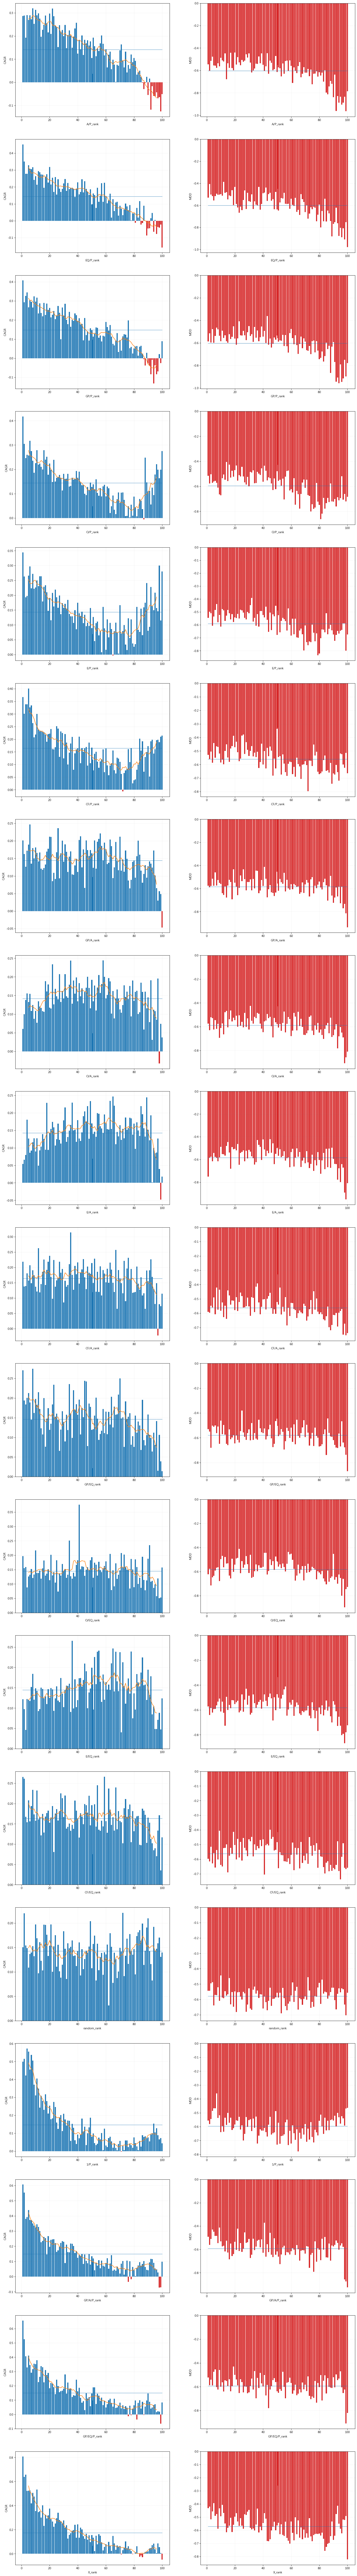

In [5]:
import matplotlib.pyplot as plt
from base import cagr, mdd
from base.time import YearMonth
from datetime import date

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, subplots = plt.subplots(len(factors), 2)
fig.set_figwidth(20), fig.set_figheight(8 * len(factors))

summary = pd.DataFrame()
for i in range(len(factors)):
    print(f"\r{i + 1}/{len(factors)}", end="")

    factor = factors[i]

    colname_rank = f"{factor}_rank"
    rank = sorted(set(result[colname_rank].dropna()))
    mean_by_rank = []
    cagr_by_rank = []
    mdd_by_rank = []
    for r in rank:
        rankers = result[result[colname_rank] == r]
        return_by_ym = rankers.groupby("매도년월")["수익률"].mean()
        begin = YearMonth.from_string(rankers["매수년월"].min())
        end = YearMonth.from_string(rankers["매도년월"].max())
        years = (end.value() - begin.value()) / 12
        cumprod = (return_by_ym + 1).cumprod()
        last = cumprod[-1]
        mean_by_rank.append(return_by_ym.mean())
        cagr_by_rank.append(cagr(1, last, years))
        dates = [date(int(s.split("-")[0]), int(s.split("-")[1]), 1) for s in return_by_ym.index]
        mdd_by_rank.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]

    cagr_by_rank_series = pd.Series(cagr_by_rank)
    mdd_by_ran_series = pd.Series(mdd_by_rank)

    ax1.set_xlabel(colname_rank)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(rank, cagr_by_rank, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_rank])
    ax1.plot(rank, [cagr_by_rank_series.mean() for _ in rank], alpha=0.5)
    ax1.plot(rank, cagr_by_rank_series.rolling(9, center=True).mean())

    ax2.set_xlabel(colname_rank)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(rank, mdd_by_rank, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_rank])
    ax2.plot(rank, [mdd_by_ran_series.mean() for _ in rank], alpha=0.5)

    corr = pd.DataFrame({colname_rank: rank, "cagr": cagr_by_rank}).corr(method="spearman")

    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": corr[colname_rank]["cagr"],
            "top": cagr_by_rank_series.head(1).mean(),
            "head3": cagr_by_rank_series.head(3).mean(),
            "tail3": cagr_by_rank_series.tail(3).mean(),
            "head3-tail3": cagr_by_rank_series.head(3).mean() - cagr_by_rank_series.tail(3).mean(),
            "mean": cagr_by_rank_series.mean(),
            "median": cagr_by_rank_series.median(),
            "mdd_head3": mdd_by_ran_series.head(3)
        }).to_frame(factor).T
    ])

summary

In [9]:
_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "X_rank"
head = 15
strategy = result.groupby(_key).apply(
    lambda values: values.sort_values(factor).head(head)["수익률"].mean())
result.groupby(_key).apply(lambda values: values.sort_values(factor).head(head))[
    ["code", "종목명", "수익률", "거래소", "매수일", "매도일", "매수가", "매도가"]]

code       종목명       수익률     거래소         매수일  \
매수년월    매도년월                                                             
2001-04 2001-05 0       009730        코센  2.003614  KOSDAQ  2001-04-30   
                1       038880      아이에이 -0.115349  KOSDAQ  2001-04-30   
                2       000950        전방  0.014981   KOSPI  2001-04-30   
                3       003460      유화증권  0.085779   KOSPI  2001-04-30   
                4       017650      대림제지 -0.029630  KOSDAQ  2001-04-30   
...                        ...       ...       ...     ...         ...   
2022-10 2022-11 385028  009200     무림페이퍼  0.141975   KOSPI  2022-10-31   
                385787  052300    초록뱀컴퍼니  0.098039  KOSDAQ  2022-10-31   
                385009  007980     태평양물산  0.500000   KOSPI  2022-10-31   
                385069  174880      장원테크  0.178248  KOSDAQ  2022-10-31   
                386586  214310  에스엘바이오닉스 -0.168044  KOSDAQ  2022-10-31   

                               매도일     매수가        매도가  
매수년월    매도년월                                           
2001-04 2001-05 0       2001-05-31  342549  1028885.0  
                1       2001-05-31    1075      951.0  
                2       2001-05-31   26700    27100.0  
                3       2001-05-31     886      962.0  
                4       2001-05-31    2700     2620.0  
...                            ...     ...        ...  
2022-10 2022-11 385028  2022-11-30    2430     2775.0  
                385787  2022-11-30     561      616.0  
                385009  2022-11-30    1200     1800.0  
                385069  2022-11-30     993     1170.0  
                386586  2022-11-30     363      302.0  

[3885 rows x 8 columns]

In [10]:
from base import cagr, mdd
from base.time import YearMonth

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})


def str_to_ym(_s: str):
    _sp = _s.split("-")
    return YearMonth(int(_sp[0]), int(_sp[1]))


begin = str_to_ym(revisions.index[0][0])
end = str_to_ym(revisions.index[-1][-1])
years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"][-1], years), cagr(1, revisions["벤치마크 누적수익률"][-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"]),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"])],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

revisions

          CAGR                                        MDD      Mean
전략    0.664901  (-0.5437729227887995, (2002-03, 2004-07))  0.049892
벤치마크  0.156130  (-0.5373814900711389, (2007-07, 2008-10))  0.014690


,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률
매수년월,매도년월,,,,,
2001-04,2001-05,0.122461,0.299019,0.18,1.122461,1.299019
2001-05,2001-06,-0.004068,-0.008514,-0.00,1.117895,1.287959
2001-06,2001-07,-0.107487,-0.050676,0.06,0.997736,1.222690
2001-07,2001-08,-0.047631,-0.074270,-0.03,0.950213,1.131881
2001-08,2001-09,-0.131081,-0.128825,0.00,0.825658,0.986066
...,...,...,...,...,...,...
2022-06,2022-07,0.064967,0.071910,0.01,24.328407,50576.360991
2022-07,2022-08,0.007675,0.018349,0.01,24.515137,51504.380160
2022-08,2022-09,-0.153449,-0.049713,0.10,20.753318,48943.966242


<BarContainer object of 259 artists>

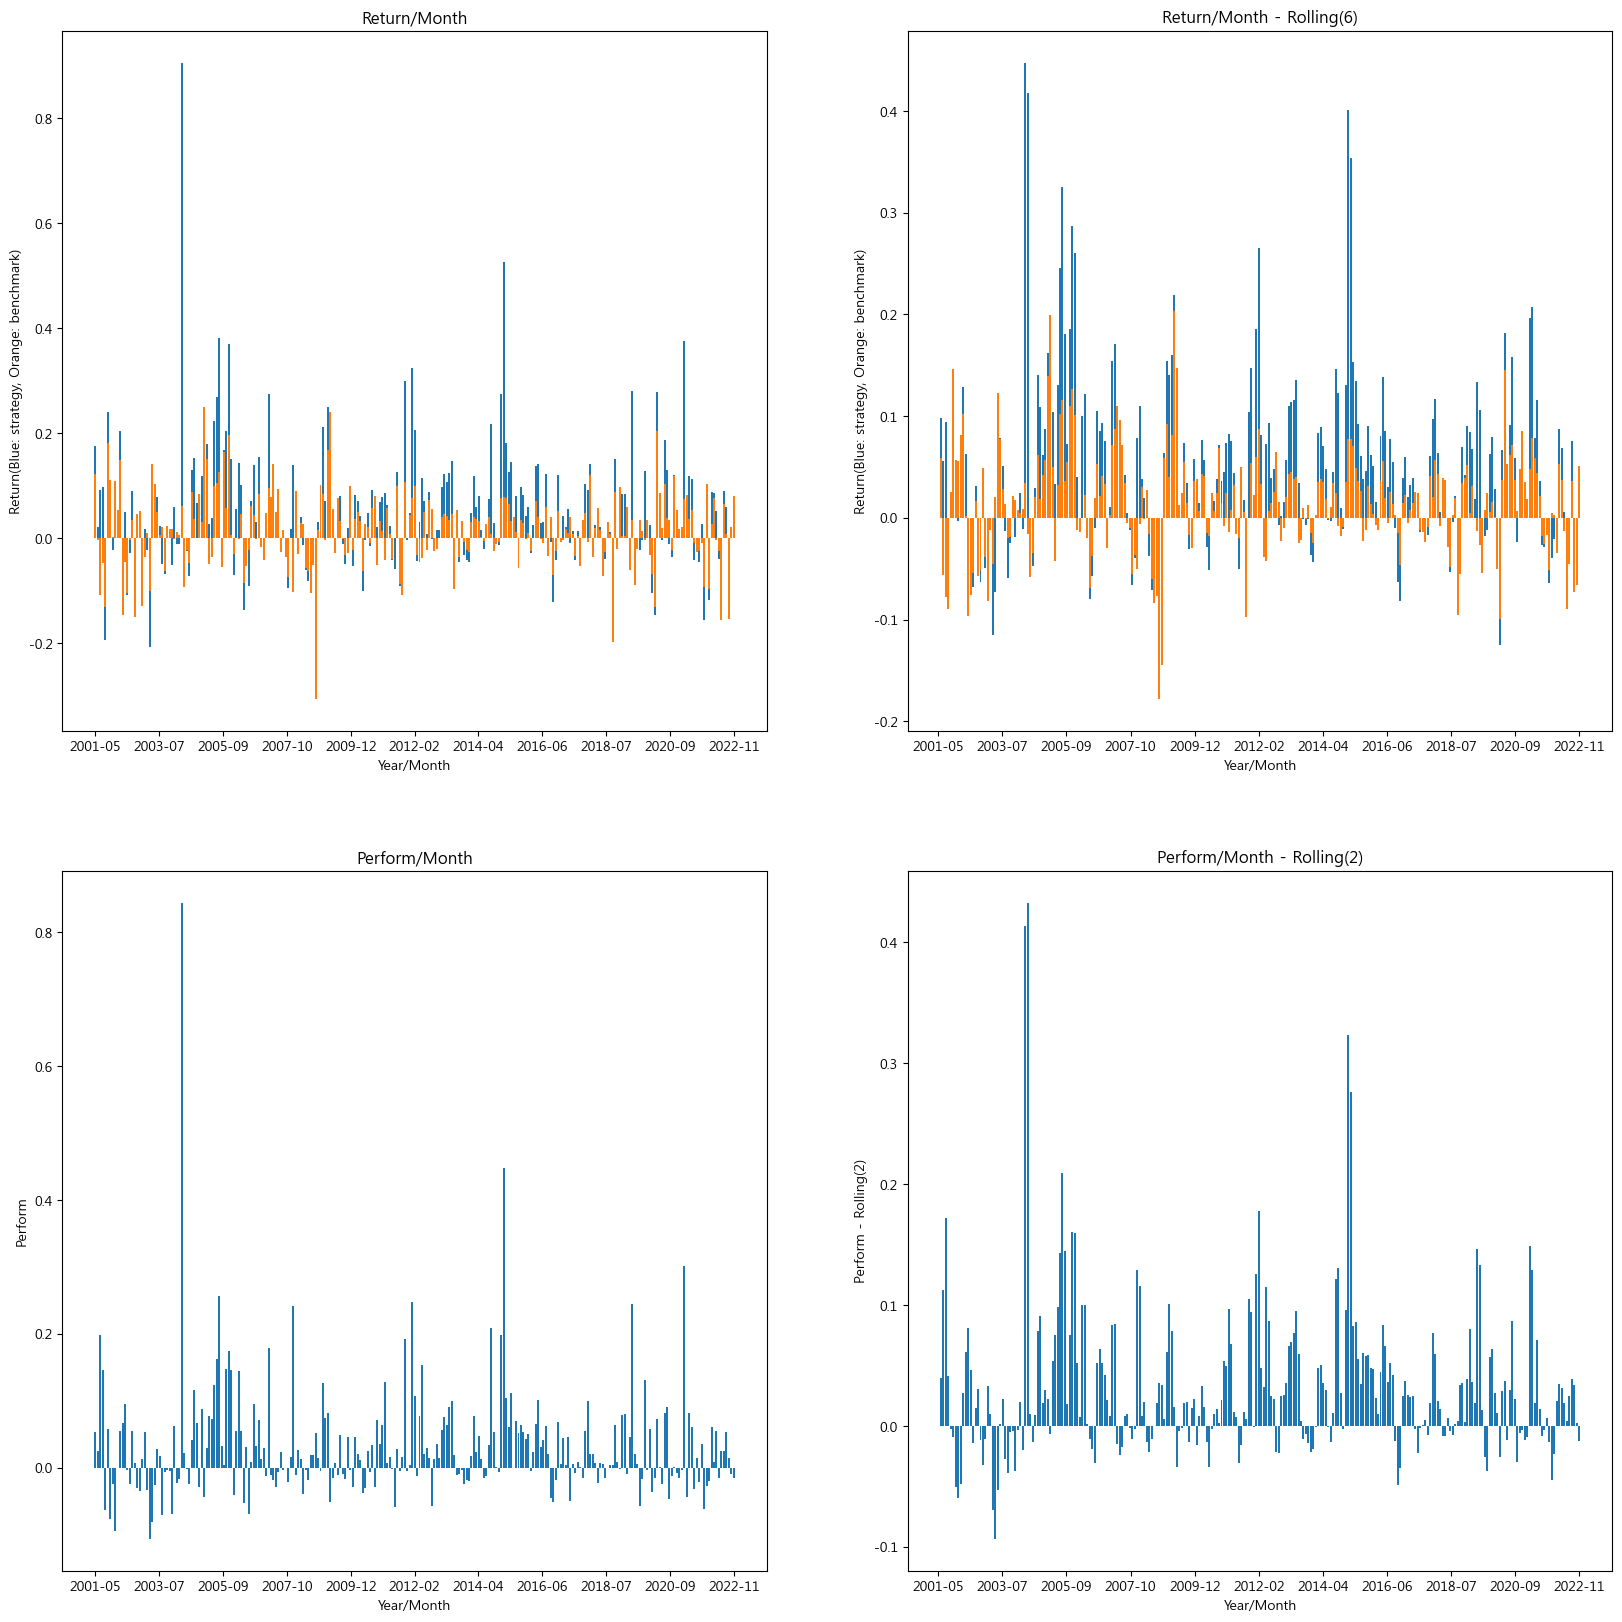

In [8]:
import numpy as np
import matplotlib.pyplot as plt

rank = [i for _, i in strategy.index]

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

x_label = "Year/Month"
y_label = "Return(Blue: strategy, Orange: benchmark)"
ax1.set_title(f"Return/Month")
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))

ax1.bar(rank, revisions["전략 수익률"])
ax1.bar(rank, revisions["벤치마크 수익률"])

window = 2
ax2.set_title("Return/Month - Rolling(6)")
ax2.set_xlabel("Year/Month"), ax2.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(rank, revisions["전략 수익률"].rolling(window).mean())
ax2.bar(rank, revisions["벤치마크 수익률"].rolling(window).mean())

ax3.set_title("Perform/Month")
ax3.set_xlabel("Year/Month"), ax3.set_ylabel("Perform")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax3.bar(rank, revisions["전략 수익률"] - revisions["벤치마크 수익률"])

ax4.set_title(f"Perform/Month - Rolling({window})")
ax4.set_xlabel("Year/Month"), ax4.set_ylabel(f"Perform - Rolling({window})")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax4.bar(rank, (revisions["전략 수익률"] - revisions["벤치마크 수익률"]).rolling(window).mean())